In [3]:
# Import necessary libraries for data manipulation, visualization, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

def clean_numeric_column(series):
    """Clean and convert a series to numeric"""
    # Convert to string first, then clean
    cleaned = series.astype(str)
    # Remove commas, spaces, and other non-numeric characters except decimal points
    cleaned = cleaned.str.replace(',', '').str.replace(' ', '')
    # Convert to numeric, coercing errors to NaN
    return pd.to_numeric(cleaned, errors='coerce')

# Load the data from CSV file
df = pd.read_csv('Google_Stock_Price_Train.csv')

# Display the first few rows of raw data
print("Raw data sample:")
print(df.head())
# Display the data types of each column
print("\nRaw data types:")
print(df.dtypes)

# Clean the 'Date' column and convert it to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# Drop rows where 'Date' could not be parsed (NaT)
df = df.dropna(subset=['Date'])
# Set 'Date' as the DataFrame index
df.set_index('Date', inplace=True)

# Define the columns that are expected to be numeric
expected_numeric = ['Open', 'High', 'Low', 'Close', 'Volume']

# Clean each expected numeric column
for col in expected_numeric:
    if col in df.columns:
        print(f"Cleaning column: {col}")
        df[col] = clean_numeric_column(df[col])
    else:
        print(f"Warning: Column {col} not found in dataset")

# Remove rows where any of the essential columns are NaN
essential_cols = ['Open', 'High', 'Low', 'Close']
available_essential = [col for col in essential_cols if col in df.columns]
df = df.dropna(subset=available_essential)

# Print the final shape of the cleaned dataset
print(f"\nFinal dataset shape: {df.shape}")
# Print the date range of the dataset
print(f"Date range: {df.index[0]} to {df.index[-1]}")
# Print the data types after cleaning
print("\nFinal data types:")
print(df.dtypes)
# Show a sample of the cleaned data
print("\nSample of cleaned ")
print(df.head())

# Verify data is numeric by testing a simple operation (percentage change)
try:
    test_calc = df['Close'].pct_change()
    print("✓ Data conversion successful - pct_change() test passed")
except Exception as e:
    print(f"✗ Data conversion failed: {e}")


Raw data sample:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800

Raw data types:
Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object
Cleaning column: Open
Cleaning column: High
Cleaning column: Low
Cleaning column: Close
Cleaning column: Volume

Final dataset shape: (1258, 5)
Date range: 2012-01-03 00:00:00 to 2016-12-30 00:00:00

Final data types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Sample of cleaned 
              Open    High     Low   Close    Volume
Date                                                
2012-01-03  325.25  332.83  324.97  663.59   7380500
2012-01

In [4]:
# Data Processor with Error Handling

class StockDataProcessor:
    def __init__(self, data):
        # Store a copy of the input data to avoid modifying the original DataFrame
        self.data = data.copy()
        # Initialize a MinMaxScaler for future scaling tasks
        self.scaler = MinMaxScaler()
        
    def create_technical_indicators(self):
        """Create technical indicators with error handling"""
        try:
            # Step 1: Ensure all relevant columns are numeric
            numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
            for col in numeric_cols:
                if col in self.data.columns:
                    if not pd.api.types.is_numeric_dtype(self.data[col]):
                        print(f"Converting {col} to numeric...")
                        self.data[col] = pd.to_numeric(self.data[col], errors='coerce')
            
            # Step 2: Drop any rows that still have NaN values after conversion
            self.data = self.data.dropna()
            
            # Step 3: Create basic technical features
            self.data['Returns'] = self.data['Close'].pct_change()  # Daily returns
            self.data['High_Low_Pct'] = (self.data['High'] - self.data['Low']) / self.data['Close'] * 100  # High-low percentage
            self.data['Price_Change'] = self.data['Close'] - self.data['Open']  # Price change from open to close
            
            # Step 4: Volume change feature (if Volume column exists)
            if 'Volume' in self.data.columns:
                self.data['Volume_Change'] = self.data['Volume'].pct_change()
            
            # Step 5: Moving averages for various windows
            self.data['MA_5'] = self.data['Close'].rolling(window=5).mean()
            self.data['MA_10'] = self.data['Close'].rolling(window=10).mean()
            self.data['MA_20'] = self.data['Close'].rolling(window=20).mean()
            self.data['MA_50'] = self.data['Close'].rolling(window=50).mean()
            
            # Step 6: Volatility as rolling standard deviation of returns
            self.data['Volatility'] = self.data['Returns'].rolling(window=10).std()
            
            # Step 7: Relative Strength Index (RSI) calculation
            delta = self.data['Close'].diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
            rs = gain / loss
            self.data['RSI'] = 100 - (100 / (1 + rs))
            
            # Step 8: Bollinger Bands (middle, upper, and lower bands)
            self.data['BB_Middle'] = self.data['Close'].rolling(window=20).mean()
            bb_std = self.data['Close'].rolling(window=20).std()
            self.data['BB_Upper'] = self.data['BB_Middle'] + (bb_std * 2)
            self.data['BB_Lower'] = self.data['BB_Middle'] - (bb_std * 2)
            
            # Step 9: Price's position within the Bollinger Bands
            self.data['BB_Position'] = (self.data['Close'] - self.data['BB_Lower']) / (self.data['BB_Upper'] - self.data['BB_Lower'])
            
            # Step 10: Drop any rows with NaN values caused by rolling calculations
            self.data = self.data.dropna()
            return self.data
            
        except Exception as e:
            # Error handling: print error, data types, and a sample of the data for debugging
            print(f"Error in create_technical_indicators: {e}")
            print("Data types:")
            print(self.data.dtypes)
            print("Sample ")
            print(self.data.head())
            raise  # Re-raise the exception for further handling
    
    def create_lagged_features(self, lookback=10):
        """Create lagged features for machine learning models"""
        # For each lag from 1 to lookback, create shifted versions of Close, Volume, and Returns
        for i in range(1, lookback + 1):
            self.data[f'Close_lag_{i}'] = self.data['Close'].shift(i)
            if 'Volume' in self.data.columns:
                self.data[f'Volume_lag_{i}'] = self.data['Volume'].shift(i)
            self.data[f'Returns_lag_{i}'] = self.data['Returns'].shift(i)
        
        # Drop rows with NaN values caused by shifting
        self.data = self.data.dropna()
        return self.data

# Instantiate the processor with your cleaned DataFrame
processor = StockDataProcessor(df)

# Create technical indicators and handle errors if any
processed_data = processor.create_technical_indicators()

# Add lagged features with a lookback window of 5
processed_data = processor.create_lagged_features(lookback=5)

# Print the shape of the final processed data and the number of features created
print(f"Processed data shape: {processed_data.shape}")
print(f"Features created: {len(processed_data.columns)}")


Processed data shape: (1204, 34)
Features created: 34


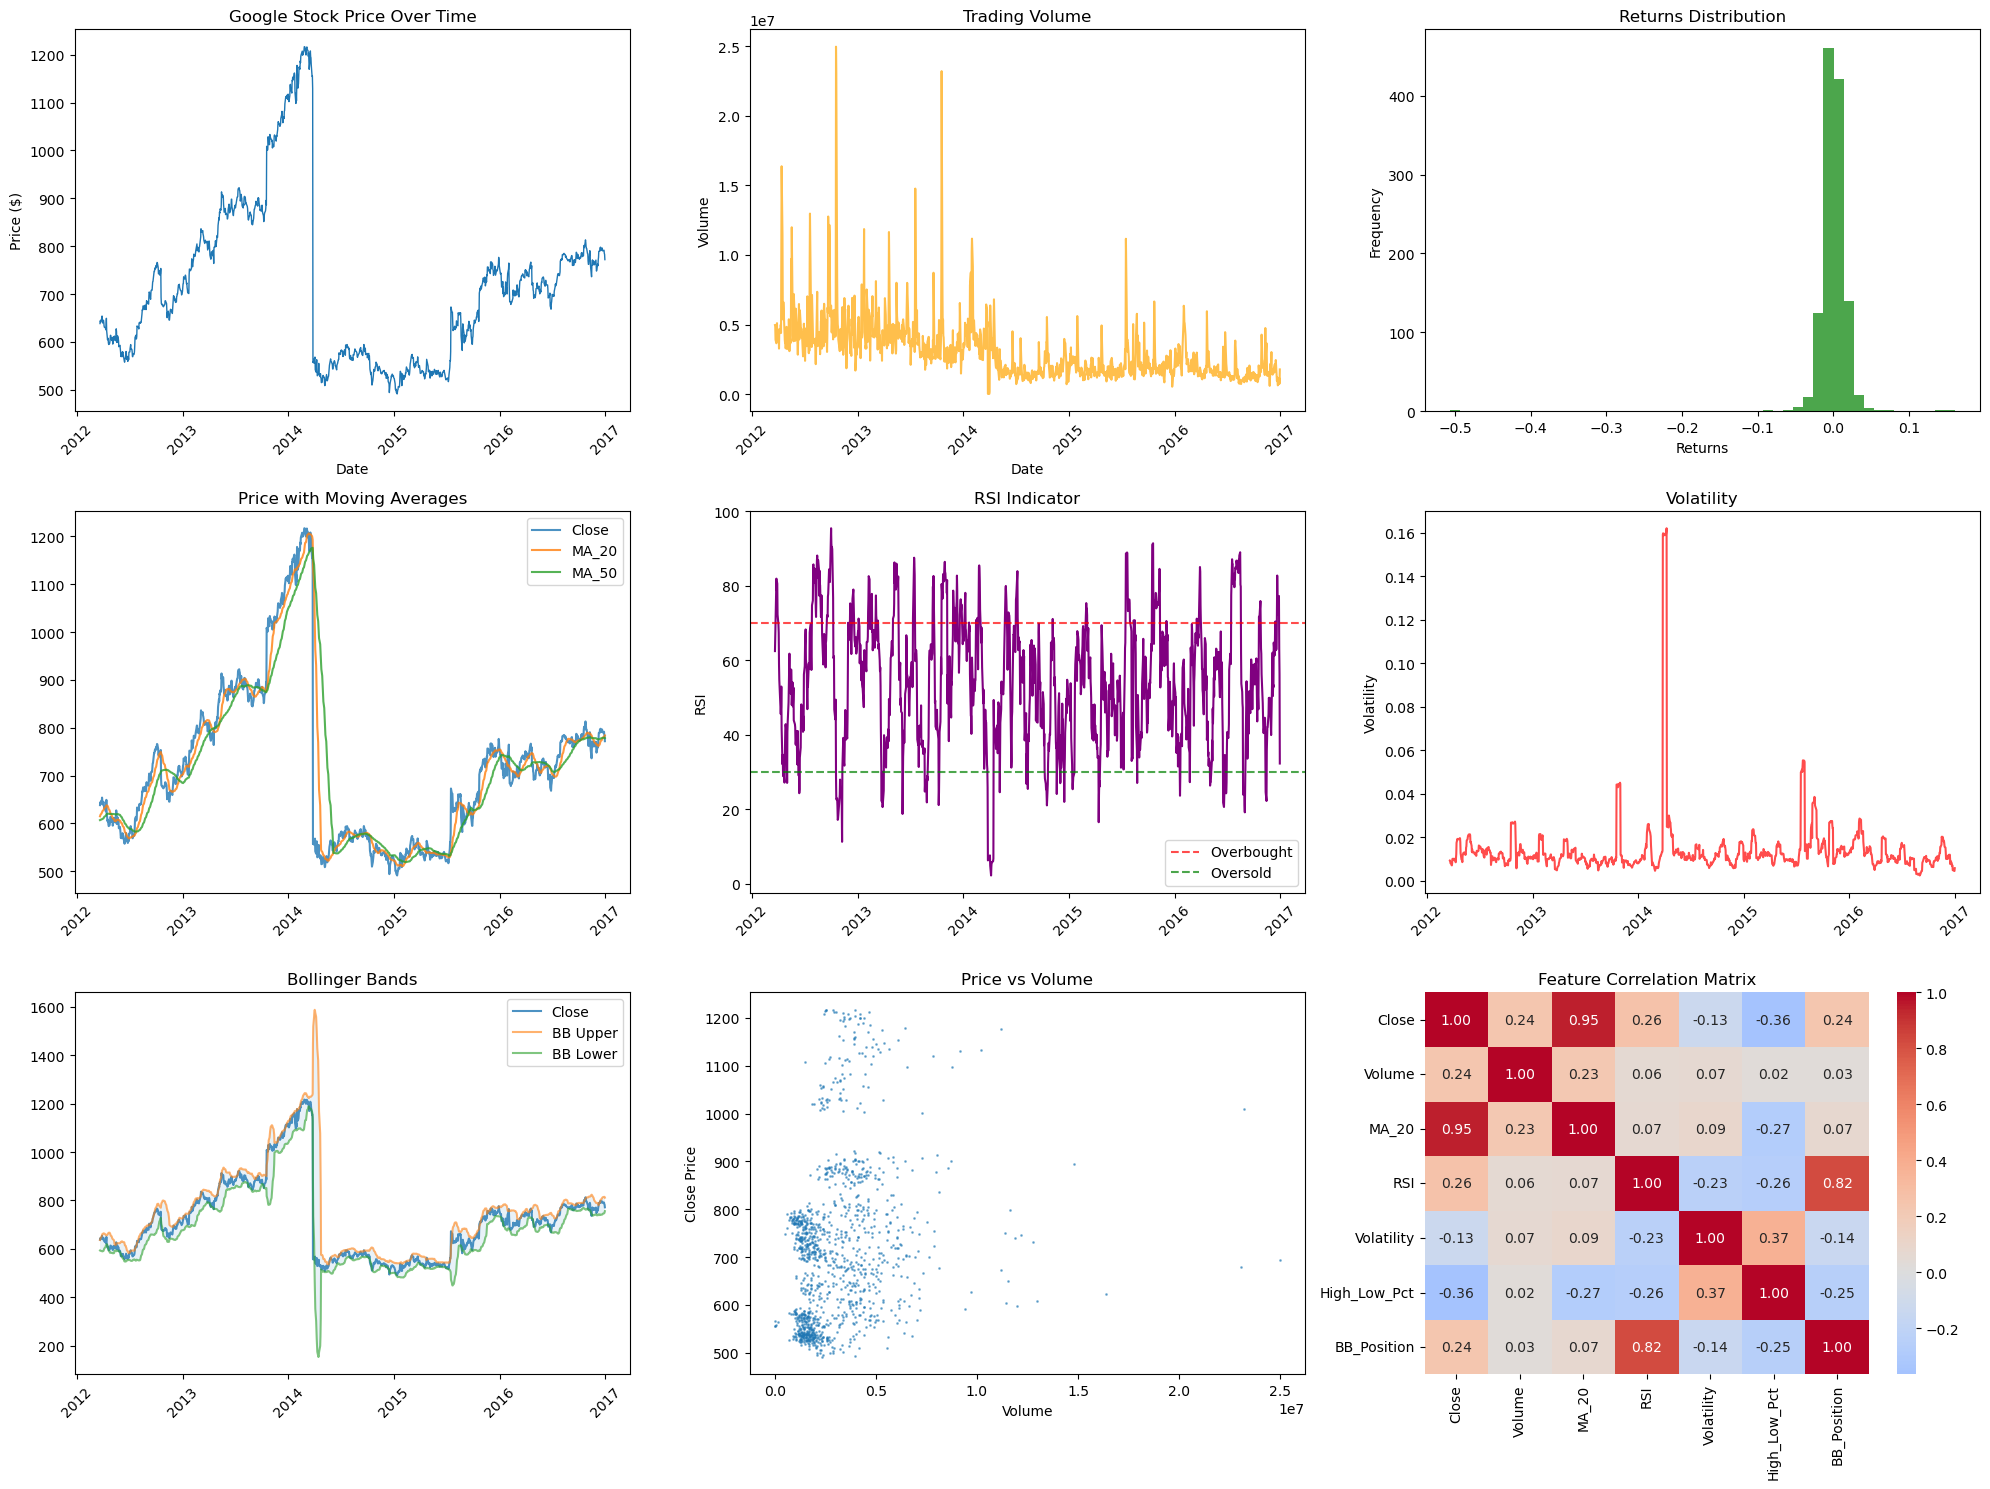


Basic Statistics:
              Open         High          Low        Close        Volume
count  1204.000000  1204.000000  1204.000000  1204.000000  1.204000e+03
mean    543.971238   548.235191   539.171453   717.253812  3.048122e+06
std     147.141318   148.179645   145.842010   166.885821  2.176192e+06
min     279.120000   281.210000   277.220000   491.200000  7.900000e+03
25%     432.252500   435.340000   430.122500   574.900000  1.593400e+06
50%     539.950000   544.095000   536.010000   703.345000  2.438800e+06
75%     665.045000   674.577500   659.145000   785.115000  4.010725e+06
max     816.680000   816.680000   805.140000  1216.830000  2.497790e+07


In [5]:
# Exploratory Data Analysis

plt.figure(figsize=(20, 15))  # Set the overall figure size

# 1. Stock price over time
plt.subplot(3, 3, 1)  # First subplot
plt.plot(processed_data.index, processed_data['Close'], linewidth=1)
plt.title('Google Stock Price Over Time', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# 2. Trading Volume over time
plt.subplot(3, 3, 2)  # Second subplot
plt.plot(processed_data.index, processed_data['Volume'], alpha=0.7, color='orange')
plt.title('Trading Volume', fontsize=12)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)

# 3. Returns distribution (histogram)
plt.subplot(3, 3, 3)  # Third subplot
plt.hist(processed_data['Returns'].dropna(), bins=50, alpha=0.7, color='green')
plt.title('Returns Distribution', fontsize=12)
plt.xlabel('Returns')
plt.ylabel('Frequency')

# 4. Moving averages with close price
plt.subplot(3, 3, 4)  # Fourth subplot
plt.plot(processed_data.index, processed_data['Close'], label='Close', alpha=0.8)
plt.plot(processed_data.index, processed_data['MA_20'], label='MA_20', alpha=0.8)
plt.plot(processed_data.index, processed_data['MA_50'], label='MA_50', alpha=0.8)
plt.title('Price with Moving Averages', fontsize=12)
plt.legend()
plt.xticks(rotation=45)

# 5. RSI indicator plot
plt.subplot(3, 3, 5)  # Fifth subplot
plt.plot(processed_data.index, processed_data['RSI'], color='purple')
plt.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')  # Overbought threshold
plt.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')    # Oversold threshold
plt.title('RSI Indicator', fontsize=12)
plt.ylabel('RSI')
plt.legend()
plt.xticks(rotation=45)

# 6. Volatility plot
plt.subplot(3, 3, 6)  # Sixth subplot
plt.plot(processed_data.index, processed_data['Volatility'], color='red', alpha=0.7)
plt.title('Volatility', fontsize=12)
plt.ylabel('Volatility')
plt.xticks(rotation=45)

# 7. Bollinger Bands visualization
plt.subplot(3, 3, 7)  # Seventh subplot
plt.plot(processed_data.index, processed_data['Close'], label='Close', alpha=0.8)
plt.plot(processed_data.index, processed_data['BB_Upper'], label='BB Upper', alpha=0.6)
plt.plot(processed_data.index, processed_data['BB_Lower'], label='BB Lower', alpha=0.6)
plt.fill_between(processed_data.index, processed_data['BB_Upper'], processed_data['BB_Lower'], alpha=0.1)
plt.title('Bollinger Bands', fontsize=12)
plt.legend()
plt.xticks(rotation=45)

# 8. Price vs Volume scatter plot
plt.subplot(3, 3, 8)  # Eighth subplot
plt.scatter(processed_data['Volume'], processed_data['Close'], alpha=0.5, s=1)
plt.title('Price vs Volume', fontsize=12)
plt.xlabel('Volume')
plt.ylabel('Close Price')

# 9. Correlation heatmap for selected features
plt.subplot(3, 3, 9)  # Ninth subplot
correlation_features = ['Close', 'Volume', 'MA_20', 'RSI', 'Volatility', 'High_Low_Pct', 'BB_Position']
corr_matrix = processed_data[correlation_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix', fontsize=12)

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display all plots

# Display basic statistics for main numeric columns
print("\nBasic Statistics:")
print(processed_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())


In [6]:
# Cell 4: ARIMA Model Implementation
class ARIMAPredictor:
    def __init__(self, data):
        # Initialize with time series data
        self.data = data
        self.model = None       # Placeholder for ARIMA model
        self.fitted_model = None  # Placeholder for fitted model
        
    def check_stationarity(self, series):
        """Check if the time series is stationary using Augmented Dickey-Fuller test"""
        # Perform ADF test
        result = adfuller(series.dropna())
        # Print test results
        print('ADF Statistic:', result[0])
        print('p-value:', result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print(f'\t{key}: {value}')
        
        # Check p-value for stationarity determination
        if result[1] <= 0.05:
            print("✓ Series is stationary")
            return True
        else:
            print("✗ Series is not stationary")
            return False
    
    def fit_model(self, order=(5,1,0)):
        """Fit ARIMA model with specified order (p,d,q)"""
        try:
            # Create ARIMA model with given parameters
            self.model = ARIMA(self.data, order=order)
            # Fit the model to the data
            self.fitted_model = self.model.fit()
            print(f"ARIMA{order} model fitted successfully")
            return self.fitted_model
        except Exception as e:
            # Handle any errors during model fitting
            print(f"Error fitting ARIMA model: {e}")
            return None
    
    def predict(self, steps=30):
        """Make future predictions (forecast)"""
        if self.fitted_model:
            # Generate point forecast
            forecast = self.fitted_model.forecast(steps=steps)
            # Generate confidence intervals
            conf_int = self.fitted_model.get_forecast(steps=steps).conf_int()
            return forecast, conf_int
        else:
            print("Model not fitted yet")
            return None, None
    
    def evaluate(self, test_data):
        """Evaluate model performance on test data"""
        if self.fitted_model:
            # Get model predictions
            predictions = self.fitted_model.fittedvalues
            # Get actual values for comparison
            actual = self.data[len(predictions):]
            if len(actual) > 0:
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(actual, predictions[-len(actual):]))
                # Calculate MAE
                mae = mean_absolute_error(actual, predictions[-len(actual):])
                return {'rmse': rmse, 'mae': mae}
        return None

# ARIMA implementation
print("=== ARIMA Model Analysis ===")
# Initialize predictor with closing price data
arima_predictor = ARIMAPredictor(processed_data['Close'])
# Check stationarity of the time series
is_stationary = arima_predictor.check_stationarity(processed_data['Close'])

# Fit ARIMA model with specified parameters
arima_model = arima_predictor.fit_model(order=(5,1,0))
# Generate 30-day forecast
arima_forecast, arima_conf_int = arima_predictor.predict(30)

# If forecast was successful, print results
if arima_forecast is not None:
    print(f"\nARIMA Forecast Summary:")
    # Print forecast range
    print(f"Next 30 days forecast range: ${arima_forecast.min():.2f} - ${arima_forecast.max():.2f}")
    # Print average forecasted price
    print(f"Average predicted price: ${arima_forecast.mean():.2f}")


=== ARIMA Model Analysis ===
ADF Statistic: -2.0424660597155806
p-value: 0.26826903528019086
Critical Values:
	1%: -3.4357974716016093
	5%: -2.8639455255208186
	10%: -2.5680507439699447
✗ Series is not stationary
ARIMA(5, 1, 0) model fitted successfully

ARIMA Forecast Summary:
Next 30 days forecast range: $771.09 - $771.35
Average predicted price: $771.13


In [7]:
# Cell 5: Machine Learning Models (Random Forest & Linear Regression)
class MLPredictor:
    def __init__(self, data):
        # Initialize with processed data
        self.data = data
        self.models = {}          # Store trained models
        self.scalers = {}         # Store feature scalers
        self.feature_importance = {}  # Store feature importance data
        
    def prepare_features(self, target_col='Close', lookback_features=True):
        """Prepare features for ML models"""
        # Define base feature set
        feature_cols = ['Open', 'High', 'Low', 'Volume', 'MA_5', 'MA_10', 'MA_20', 
                       'RSI', 'Volatility', 'High_Low_Pct', 'BB_Position']
        
        # Optionally include lagged features
        if lookback_features:
            lag_cols = [col for col in self.data.columns if 'lag_' in col]
            feature_cols.extend(lag_cols)
        
        # Ensure target column isn't included in features
        feature_cols = [col for col in feature_cols if col != target_col and col in self.data.columns]
        
        # Create feature matrix (X) and target vector (y)
        X = self.data[feature_cols].copy()
        y = self.data[target_col].copy()
        
        # Clean data by removing rows with missing values
        mask = ~(X.isnull().any(axis=1) | y.isnull())
        X = X[mask]
        y = y[mask]
        
        return X, y, feature_cols
    
    def train_models(self, test_size=0.2):
        """Train multiple ML models"""
        # Prepare features and target
        X, y, feature_cols = self.prepare_features()
        
        # Time series split (maintain temporal order)
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
        y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
        
        # Scale features using MinMaxScaler
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        self.scalers['feature_scaler'] = scaler
        
        # Define models to train
        models_to_train = {
            'Linear Regression': LinearRegression(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
        }
        
        # Dictionary to store results
        results = {}
        
        # Train each model
        for name, model in models_to_train.items():
            print(f"\nTraining {name}...")
            
            # Handle model-specific training requirements
            if name == 'Linear Regression':
                # Linear Regression requires scaled features
                model.fit(X_train_scaled, y_train)
                train_pred = model.predict(X_train_scaled)
                test_pred = model.predict(X_test_scaled)
            else:
                # Random Forest works better with unscaled data
                model.fit(X_train, y_train)
                train_pred = model.predict(X_train)
                test_pred = model.predict(X_test)
            
            # Calculate performance metrics
            train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
            test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
            test_mae = mean_absolute_error(y_test, test_pred)
            test_r2 = r2_score(y_test, test_pred)
            
            # Store model and results
            results[name] = {
                'model': model,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'test_mae': test_mae,
                'test_r2': test_r2,
                'y_test': y_test,
                'test_pred': test_pred,
                'feature_cols': feature_cols
            }
            
            # Extract and store feature importance for tree-based models
            if hasattr(model, 'feature_importances_'):
                importance_df = pd.DataFrame({
                    'feature': feature_cols,
                    'importance': model.feature_importances_
                }).sort_values('importance', ascending=False)
                self.feature_importance[name] = importance_df
            
            # Print evaluation metrics
            print(f"{name} Results:")
            print(f"  Train RMSE: ${train_rmse:.2f}")
            print(f"  Test RMSE: ${test_rmse:.2f}")
            print(f"  Test MAE: ${test_mae:.2f}")
            print(f"  Test R²: {test_r2:.4f}")
        
        # Store all results
        self.models = results
        return results

# Train ML models
print("=== Machine Learning Models ===")
# Initialize predictor with processed data
ml_predictor = MLPredictor(processed_data)
# Train models and store results
ml_results = ml_predictor.train_models()


=== Machine Learning Models ===

Training Linear Regression...
Linear Regression Results:
  Train RMSE: $0.00
  Test RMSE: $0.00
  Test MAE: $0.00
  Test R²: 1.0000

Training Random Forest...
Random Forest Results:
  Train RMSE: $6.30
  Test RMSE: $49.90
  Test MAE: $25.39
  Test R²: -1.0785


In [8]:
# Cell 6: Simple LSTM Implementation (without TensorFlow)
class SimpleLSTMPredictor:
    def __init__(self, data):
        # Initialize with time series data
        self.data = data
        # Initialize MinMaxScaler for feature scaling
        self.scaler = MinMaxScaler()
        
    def prepare_sequences(self, sequence_length=60):
        """Prepare sequences for LSTM-style prediction"""
        # Scale closing prices to [0,1] range
        scaled_data = self.scaler.fit_transform(self.data['Close'].values.reshape(-1, 1))
        
        # Create sequences and targets
        X, y = [], []
        for i in range(sequence_length, len(scaled_data)):
            # Each X sequence contains 'sequence_length' previous values
            X.append(scaled_data[i-sequence_length:i, 0])
            # y contains the next value after the sequence
            y.append(scaled_data[i, 0])
        
        return np.array(X), np.array(y)
    
    def simple_rnn_predict(self, test_size=0.2, sequence_length=60):
        """Simple RNN-style prediction using moving averages and trends"""
        # Prepare sequences and targets
        X, y = self.prepare_sequences(sequence_length)
        
        # Split into train/test sets while maintaining temporal order
        split_idx = int(len(X) * (1 - test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Store predictions
        predictions = []
        
        # Make predictions for each test sequence
        for i, sequence in enumerate(X_test):
            # Calculate trend from last 10 points in sequence
            trend = np.mean(np.diff(sequence[-10:]))
            
            # Create exponentially weighted average (more weight to recent values)
            weights = np.exp(np.linspace(-1, 0, len(sequence)))
            weights /= weights.sum()  # Normalize weights
            weighted_avg = np.average(sequence, weights=weights)
            
            # Combine weighted average with amplified trend
            prediction = weighted_avg + trend * 3
            predictions.append(prediction)
        
        predictions = np.array(predictions)
        
        # Inverse transform to original price scale
        y_test_actual = self.scaler.inverse_transform(y_test.reshape(-1, 1))
        predictions_actual = self.scaler.inverse_transform(predictions.reshape(-1, 1))
        
        # Calculate performance metrics
        rmse = np.sqrt(mean_squared_error(y_test_actual, predictions_actual))
        mae = mean_absolute_error(y_test_actual, predictions_actual)
        r2 = r2_score(y_test_actual, predictions_actual)
        
        return {
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'y_test': y_test_actual.flatten(),
            'predictions': predictions_actual.flatten()
        }
    
    def predict_future(self, days=30, sequence_length=60):
        """Predict future prices using a recursive approach"""
        # Get last available sequence
        last_sequence = self.scaler.transform(
            self.data['Close'].tail(sequence_length).values.reshape(-1, 1)
        ).flatten()
        
        future_predictions = []
        current_sequence = last_sequence.copy()
        
        # Generate predictions for future days
        for _ in range(days):
            # Calculate trend from last 10 points
            trend = np.mean(np.diff(current_sequence[-10:]))
            # Create exponentially weighted average
            weights = np.exp(np.linspace(-1, 0, len(current_sequence)))
            weights /= weights.sum()
            weighted_avg = np.average(current_sequence, weights=weights)
            
            # Predict next value using weighted average and amplified trend
            next_pred = weighted_avg + trend * 3
            future_predictions.append(next_pred)
            
            # Update sequence by removing oldest value and adding new prediction
            current_sequence = np.append(current_sequence[1:], next_pred)
        
        # Convert predictions back to original price scale
        future_predictions = self.scaler.inverse_transform(
            np.array(future_predictions).reshape(-1, 1)
        ).flatten()
        
        return future_predictions

# Simple LSTM-style prediction
print("\n=== Simple Sequential Model ===")
# Initialize predictor with processed data
lstm_predictor = SimpleLSTMPredictor(processed_data)
# Get evaluation results
lstm_results = lstm_predictor.simple_rnn_predict()

# Print evaluation metrics
print(f"Simple Sequential Model Results:")
print(f"  Test RMSE: ${lstm_results['rmse']:.2f}")
print(f"  Test MAE: ${lstm_results['mae']:.2f}")
print(f"  Test R²: {lstm_results['r2']:.4f}")

# Generate 30-day future predictions
future_predictions = lstm_predictor.predict_future(30)
# Print prediction summary
print(f"\nFuture 30-day predictions:")
print(f"  Range: ${future_predictions.min():.2f} - ${future_predictions.max():.2f}")
print(f"  Average: ${future_predictions.mean():.2f}")



=== Simple Sequential Model ===
Simple Sequential Model Results:
  Test RMSE: $20.85
  Test MAE: $17.04
  Test R²: 0.6422

Future 30-day predictions:
  Range: $770.70 - $779.78
  Average: $775.35


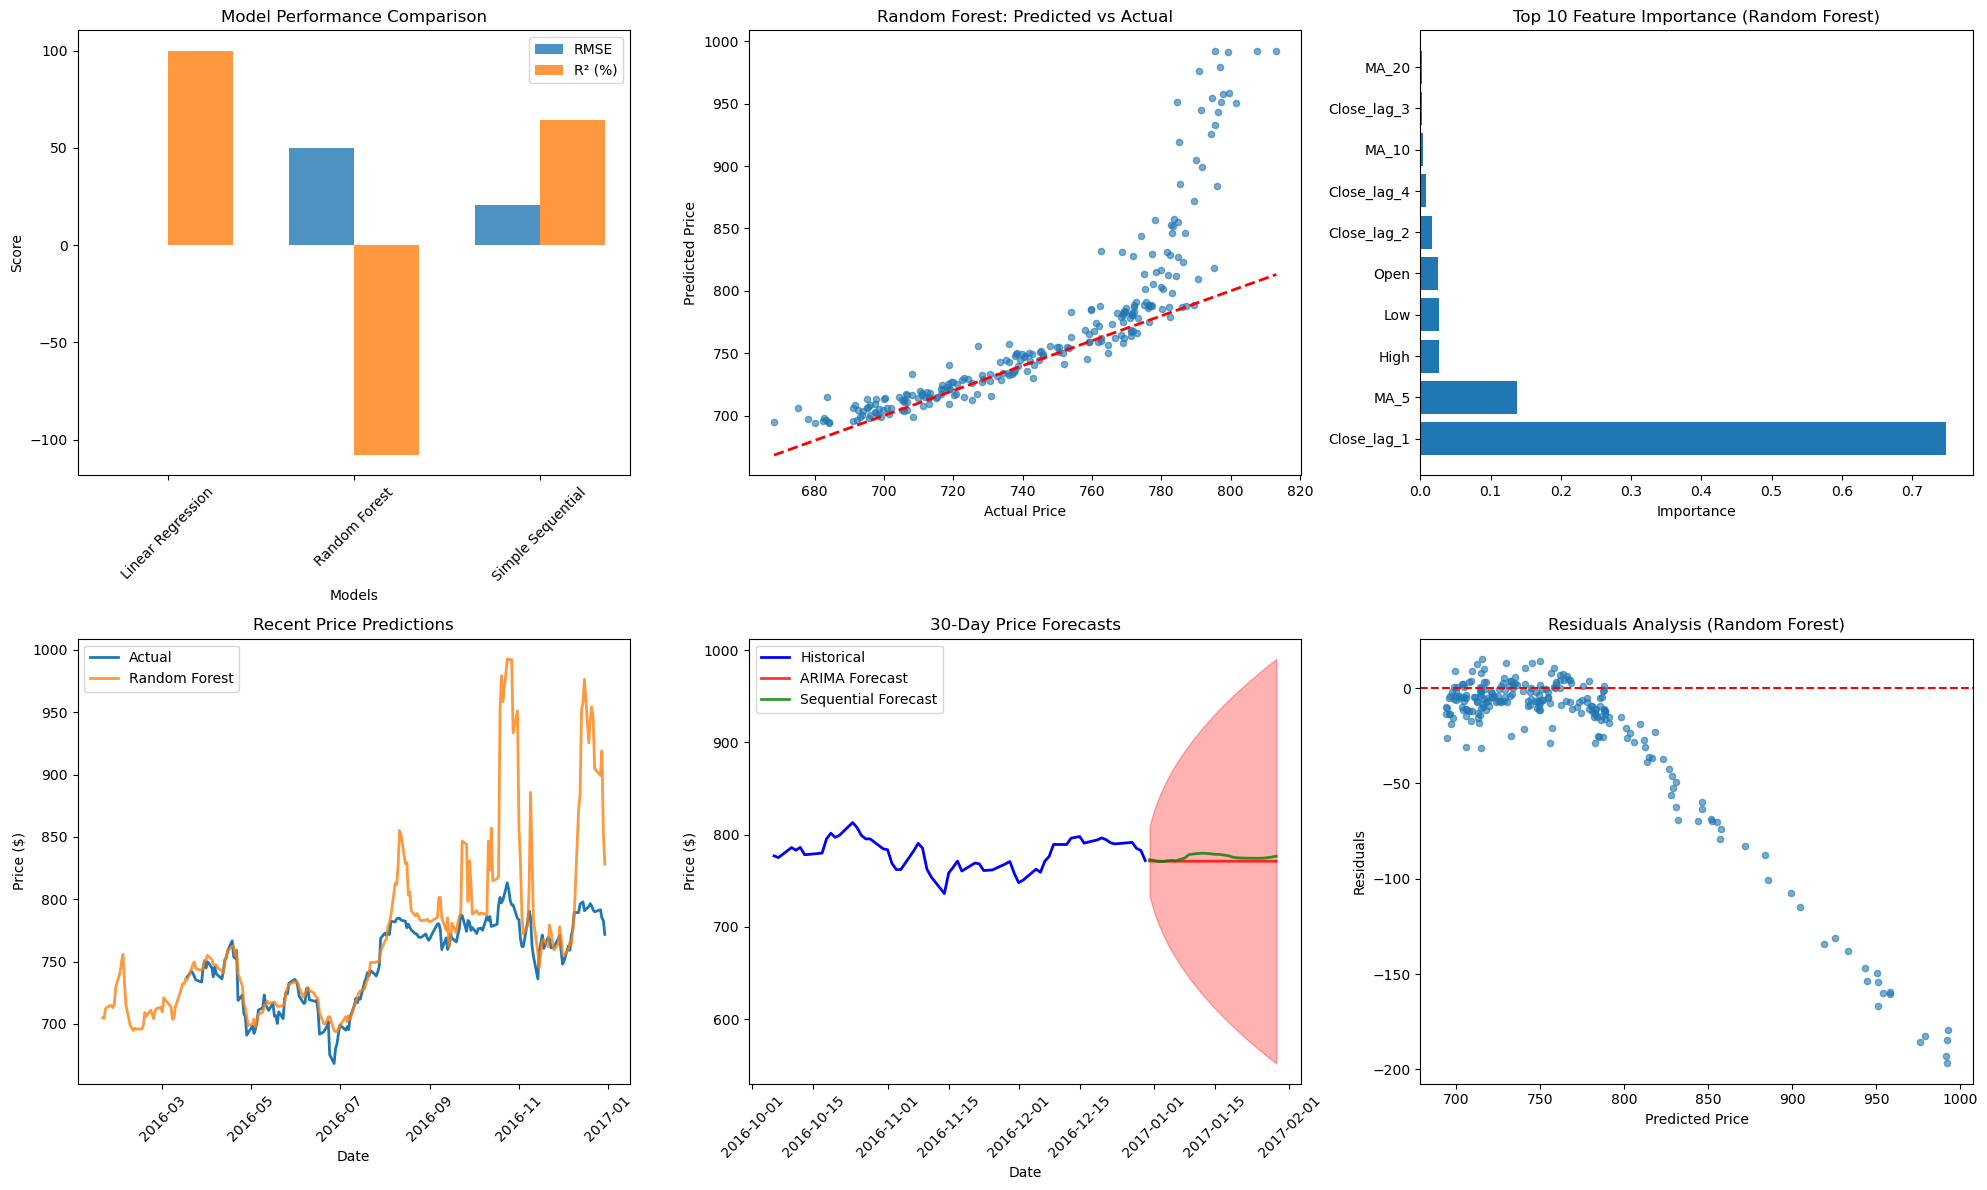

In [9]:
# Cell 7: Model Comparison and Visualization
def create_comparison_plots():
    """Create comprehensive comparison plots"""
    # Create 2x3 grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Model performance comparison (bar chart)
    ax1 = axes[0, 0]
    # Get model names and scores
    models = list(ml_results.keys()) + ['Simple Sequential']
    rmse_scores = [ml_results[model]['test_rmse'] for model in ml_results.keys()] + [lstm_results['rmse']]
    r2_scores = [ml_results[model]['test_r2'] for model in ml_results.keys()] + [lstm_results['r2']]
    
    # Set up bar positions
    x = np.arange(len(models))
    width = 0.35
    
    # Plot RMSE and R² scores
    ax1.bar(x - width/2, rmse_scores, width, label='RMSE', alpha=0.8)
    ax1.bar(x + width/2, [r2*100 for r2 in r2_scores], width, label='R² (%)', alpha=0.8)
    ax1.set_xlabel('Models')
    ax1.set_ylabel('Score')
    ax1.set_title('Model Performance Comparison')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    
    # 2. Random Forest: Predicted vs Actual (scatter plot)
    ax2 = axes[0, 1]
    if 'Random Forest' in ml_results:
        rf_results = ml_results['Random Forest']
        # Scatter plot of predictions vs actuals
        ax2.scatter(rf_results['y_test'], rf_results['test_pred'], alpha=0.6, s=20)
        # Add perfect prediction line
        ax2.plot([rf_results['y_test'].min(), rf_results['y_test'].max()], 
                [rf_results['y_test'].min(), rf_results['y_test'].max()], 'r--', lw=2)
        ax2.set_xlabel('Actual Price')
        ax2.set_ylabel('Predicted Price')
        ax2.set_title('Random Forest: Predicted vs Actual')
    
    # 3. Feature importance for Random Forest (horizontal bar chart)
    ax3 = axes[0, 2]
    if 'Random Forest' in ml_predictor.feature_importance:
        # Get top 10 important features
        importance_df = ml_predictor.feature_importance['Random Forest'].head(10)
        # Create horizontal bar chart
        ax3.barh(range(len(importance_df)), importance_df['importance'])
        ax3.set_yticks(range(len(importance_df)))
        ax3.set_yticklabels(importance_df['feature'])
        ax3.set_xlabel('Importance')
        ax3.set_title('Top 10 Feature Importance (Random Forest)')
    
    # 4. Recent price predictions (time series plot)
    ax4 = axes[1, 0]
    # Get last 200 days of actual prices
    recent_data = processed_data.tail(200)
    ax4.plot(recent_data.index, recent_data['Close'], label='Actual', linewidth=2)
    
    # Add Random Forest predictions if available
    if 'Random Forest' in ml_results:
        # Get dates corresponding to test period
        rf_test_dates = processed_data.index[-len(ml_results['Random Forest']['y_test']):]
        ax4.plot(rf_test_dates, ml_results['Random Forest']['test_pred'], 
                label='Random Forest', alpha=0.8, linewidth=2)
    
    ax4.set_title('Recent Price Predictions')
    ax4.set_xlabel('Date')
    ax4.set_ylabel('Price ($)')
    ax4.legend()
    ax4.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
    # 5. Future predictions comparison (time series forecast)
    ax5 = axes[1, 1]
    # Get last date in dataset
    last_date = processed_data.index[-1]
    # Generate next 30 days of dates
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
    
    # Plot last 60 days of actual prices
    recent_actual = processed_data['Close'].tail(60)
    ax5.plot(recent_actual.index, recent_actual.values, label='Historical', 
            color='blue', linewidth=2)
    
    # Plot ARIMA forecast if available
    if arima_forecast is not None:
        ax5.plot(future_dates, arima_forecast, label='ARIMA Forecast', 
                color='red', alpha=0.8, linewidth=2)
        # Add confidence interval if available
        if arima_conf_int is not None:
            ax5.fill_between(future_dates, arima_conf_int.iloc[:, 0], 
                           arima_conf_int.iloc[:, 1], alpha=0.3, color='red')
    
    # Plot Sequential model forecast
    ax5.plot(future_dates, future_predictions, label='Sequential Forecast', 
            color='green', alpha=0.8, linewidth=2)
    
    ax5.set_title('30-Day Price Forecasts')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Price ($)')
    ax5.legend()
    ax5.tick_params(axis='x', rotation=45)  # Rotate x-axis labels
    
    # 6. Residuals analysis for Random Forest (scatter plot)
    ax6 = axes[1, 2]
    if 'Random Forest' in ml_results:
        # Calculate residuals (actual - predicted)
        residuals = ml_results['Random Forest']['y_test'] - ml_results['Random Forest']['test_pred']
        # Plot residuals against predictions
        ax6.scatter(ml_results['Random Forest']['test_pred'], residuals, alpha=0.6, s=20)
        # Add zero line for reference
        ax6.axhline(y=0, color='r', linestyle='--')
        ax6.set_xlabel('Predicted Price')
        ax6.set_ylabel('Residuals')
        ax6.set_title('Residuals Analysis (Random Forest)')
    
    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()

# Generate the comparison plots
create_comparison_plots()


In [10]:
# Cell 8: Final Summary and Model Insights
def print_final_summary():
    """Print comprehensive model summary"""
    # Print header
    print("="*80)
    print("STOCK PRICE PREDICTION MODEL SUMMARY")
    print("="*80)
    
    # Dataset information
    print(f"\n📊 DATASET INFORMATION:")
    print(f"   • Stock: Google (GOOGL)")
    print(f"   • Data Points: {len(processed_data):,}")
    print(f"   • Date Range: {processed_data.index[0].strftime('%Y-%m-%d')} to {processed_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"   • Features Created: {len(processed_data.columns)}")
    
    # Model performance comparison table
    print(f"\n🎯 MODEL PERFORMANCE COMPARISON:")
    print(f"{'Model':<20} {'RMSE':<12} {'MAE':<12} {'R²':<12}")
    print("-" * 60)
    
    # Print results for each ML model
    for model_name, results in ml_results.items():
        print(f"{model_name:<20} ${results['test_rmse']:<11.2f} ${results['test_mae']:<11.2f} {results['test_r2']:<11.4f}")
    
    # Print results for sequential model
    print(f"{'Simple Sequential':<20} ${lstm_results['rmse']:<11.2f} ${lstm_results['mae']:<11.2f} {lstm_results['r2']:<11.4f}")
    
    # Future price predictions
    print(f"\n🔮 FUTURE PREDICTIONS (Next 30 Days):")
    if arima_forecast is not None:
        print(f"   • ARIMA Model: ${arima_forecast.min():.2f} - ${arima_forecast.max():.2f} (Avg: ${arima_forecast.mean():.2f})")
    print(f"   • Sequential Model: ${future_predictions.min():.2f} - ${future_predictions.max():.2f} (Avg: ${future_predictions.mean():.2f})")
    
    # Determine best performing model
    best_model = min(ml_results.keys(), key=lambda x: ml_results[x]['test_rmse'])
    best_rmse = ml_results[best_model]['test_rmse']
    
    # Check if sequential model is better
    if lstm_results['rmse'] < best_rmse:
        best_model = 'Simple Sequential'
        best_rmse = lstm_results['rmse']
    
    # Print best model information
    print(f"\n🏆 BEST PERFORMING MODEL: {best_model}")
    print(f"   • Lowest RMSE: ${best_rmse:.2f}")
    
    # Key insights section
    print(f"\n📈 KEY INSIGHTS:")
    # Print top 3 features if available
    if 'Random Forest' in ml_predictor.feature_importance:
        top_features = ml_predictor.feature_importance['Random Forest'].head(3)
        print(f"   • Top 3 Most Important Features:")
        for i, (_, row) in enumerate(top_features.iterrows(), 1):
            print(f"     {i}. {row['feature']} (Importance: {row['importance']:.3f})")
    
    # Current market indicators
    current_price = processed_data['Close'].iloc[-1]
    print(f"   • Current Price: ${current_price:.2f}")
    print(f"   • Price Volatility (10-day): {processed_data['Volatility'].iloc[-1]:.4f}")
    print(f"   • RSI: {processed_data['RSI'].iloc[-1]:.1f}")
    
    # Market signal based on RSI
    if processed_data['RSI'].iloc[-1] > 70:
        print(f"   • Signal: Potentially Overbought")
    elif processed_data['RSI'].iloc[-1] < 30:
        print(f"   • Signal: Potentially Oversold")
    else:
        print(f"   • Signal: Neutral")
    
    # Important disclaimers
    print(f"\n⚠️  IMPORTANT DISCLAIMERS:")
    print(f"   • These predictions are for educational purposes only")
    print(f"   • Past performance does not guarantee future results")
    print(f"   • Always consult with financial advisors before making investment decisions")
    print(f"   • Consider multiple factors beyond technical analysis")
    
    # Footer
    print("="*80)

# Execute the summary function
print_final_summary()

# Save predictions to CSV
# Create DataFrame with future dates
predictions_df = pd.DataFrame({
    'Date': pd.date_range(start=processed_data.index[-1] + pd.Timedelta(days=1), periods=30),
    'Sequential_Prediction': future_predictions
})

# Add ARIMA predictions if available
if arima_forecast is not None:
    predictions_df['ARIMA_Prediction'] = arima_forecast.values

# Print confirmation and sample of predictions
print(f"\n💾 Predictions saved to DataFrame:")
print(predictions_df.head(10))


STOCK PRICE PREDICTION MODEL SUMMARY

📊 DATASET INFORMATION:
   • Stock: Google (GOOGL)
   • Data Points: 1,204
   • Date Range: 2012-03-21 to 2016-12-30
   • Features Created: 34

🎯 MODEL PERFORMANCE COMPARISON:
Model                RMSE         MAE          R²          
------------------------------------------------------------
Linear Regression    $0.00        $0.00        1.0000     
Random Forest        $49.90       $25.39       -1.0785    
Simple Sequential    $20.85       $17.04       0.6422     

🔮 FUTURE PREDICTIONS (Next 30 Days):
   • ARIMA Model: $771.09 - $771.35 (Avg: $771.13)
   • Sequential Model: $770.70 - $779.78 (Avg: $775.35)

🏆 BEST PERFORMING MODEL: Linear Regression
   • Lowest RMSE: $0.00

📈 KEY INSIGHTS:
   • Top 3 Most Important Features:
     1. Close_lag_1 (Importance: 0.749)
     2. MA_5 (Importance: 0.137)
     3. High (Importance: 0.027)
   • Current Price: $771.82
   • Price Volatility (10-day): 0.0058
   • RSI: 32.2
   • Signal: Neutral

⚠️  IMPORTANT